In [1]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import spacy

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, HashingVectorizer

from wordcloud import WordCloud


%matplotlib inline 

Mounted at /content/drive


In [2]:
traindf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/ΑΙ_2/prj1/vs_train.csv")
valdf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/ΑΙ_2/prj1/vs_dev.csv")

truedf = traindf[traindf['label']==2]
falsedf = traindf[traindf['label']==1]
neutraldf = traindf[traindf['label']==0]


#traindf = traindf.head(1000)
#valdf = valdf.head(1000)


## Visualize the most common words of tweets:

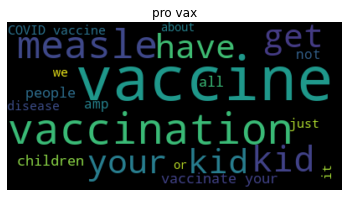

In [ ]:
stopWordsList = ['that','it','are','in','as','this','the','with','they','their','and','an','a','at','to','for','by','his','her','is','for','of','in','from','him','on','http','https','co','you','so','but','if','no','my','ha','me']


wordcloud = WordCloud( max_words=20,margin=0,stopwords=stopWordsList).generate(" ".join(truedf['tweet'].tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("pro vax")
plt.axis("off")
plt.show()

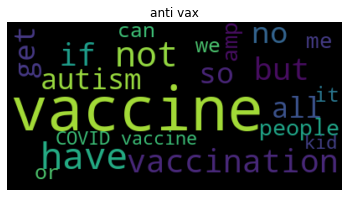

In [38]:
wordcloud = WordCloud( max_words=20,margin=0,stopwords=stopWordsList).generate(" ".join(falsedf['tweet'].tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("anti vax")
plt.axis("off")
plt.show()

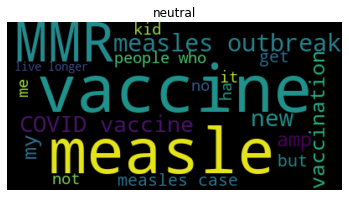

In [39]:
wordcloud = WordCloud( max_words=20,margin=0,stopwords=stopWordsList).generate(" ".join(neutraldf['tweet'].tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("neutral")
plt.axis("off")
plt.show()

## visualize average of words per tweet in every category:

Text(0.5, 1.0, 'average of words of tweet')

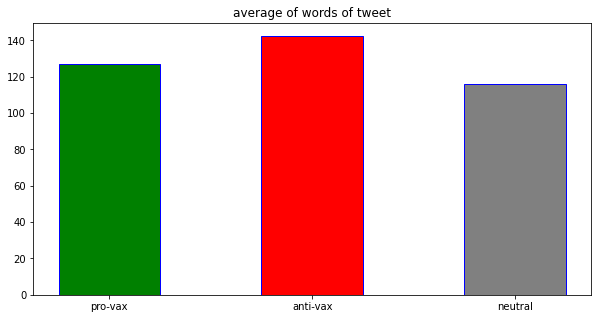

In [ ]:
sum_true = truedf['tweet'].apply(lambda x: len(x))    # this a column with the sum of words for every tweet
avg_true = sum_true.sum() / sum_true.shape[0]

sum_false = falsedf['tweet'].apply(lambda x: len(x))
avg_false = sum_false.sum() / sum_false.shape[0]

sum_neutral= neutraldf['tweet'].apply(lambda x: len(x))
avg_neutral = sum_neutral.sum() / sum_neutral.shape[0]


###################### PLOTS #######################


fig, axs = plt.subplots(1,1,figsize=(10, 5))
y_axis = [avg_true,avg_false,avg_neutral]
x_axis = ["pro-vax", "anti-vax","neutral"]
axs.bar(x_axis,y_axis,color=['green','red','gray'],edgecolor='blue',width=0.5)
axs.set_title("average of words of tweet")



# Pre-processing of tweets with spacy


In [4]:
nlp = spacy.load("en_core_web_sm")
stopSet = {'.', ',', '-', '!', '$', '%', '^','&','*','(',')','_','+','=','\'','\"',':','—'}
traindf_list = []
def lemmatization(column):
  count=0
  lemmatized = []
  for x in column:
    spaced = nlp(x)
    lemmastr = ""
    for token in spaced:
      if token.is_stop == False and not token.lemma_ in stopSet:
        lemmastr += str(token.lemma_+' ')
    lemmatized.append(lemmastr)
    count+=1
    if(count >1000):
      count = 0
      print(count)

  return lemmatized



##Softmax regression:

In [40]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

stopWordsList = ['that','it','are','in','as','this','the','with','they','their','and','an','a','at','to','for','by','his','her','is','for','of','in','from','him','on','http','https','co','you']


# bag of words vectorizer
def bow_fun(rrange,maxf):
  bow_vectorizer = CountVectorizer(max_df=0.80, min_df=1, max_features=maxf,ngram_range=rrange,stop_words=stopWordsList, lowercase=False)
  return bow_vectorizer;

# tf idf vectorizer
def tfidf_fun(rrange,maxf):
  tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=1, max_features=maxf,ngram_range=rrange,stop_words=stopWordsList, lowercase=False)
  return tfidf_vectorizer;

# hashing vectorizer
def hash_fun(rrange,maxf):
  hash_vectorizer = HashingVectorizer(n_features=maxf,ngram_range=rrange,stop_words=stopWordsList, lowercase=False)
  return hash_vectorizer;

# function to compute learning curve and plot
def learning_curves(estimator, x, y, train_sizes, cv, vectorizer):

  train_sizes, train_scores, validation_scores = learning_curve(
  estimator, x,  y, train_sizes = train_sizes,
  cv = cv,
   scoring = 'f1_weighted')  #neg_mean_squared_error

  train_scores_mean = train_scores.mean(axis = 1)
  validation_scores_mean = validation_scores.mean(axis = 1)
  
  plt.plot(train_sizes, train_scores_mean, label = 'Training error', linestyle = '-', marker='o')
  plt.plot(train_sizes, validation_scores_mean, label = 'Validation error',linestyle = '-', marker='o')

  #some visual add-ons
  plt.grid()
  plt.ylabel('f1 score', fontsize = 14)
  plt.xlabel('Training set size', fontsize = 14)
  title = str(vectorizer)
  plt.title(title, fontsize = 18, y = 1.03)
  plt.legend()
  plt.ylim(0,1)
  plt.yticks(np.arange(0.0,1.0, 0.1))



In [41]:

#########################################
######   CLASSIFICATION FUNCTION   ######

def classify(traindf,testdf,train_sizes):
  plt.figure(figsize = (16,6))

  for vectorizer, i in [("bow", 1), ("tfidf",2),("hash",3)]:
    if vectorizer == "bow":
      model = LogisticRegression(multi_class = 'multinomial', solver = 'saga', penalty = 'l2', C = 0.05, max_iter=1000)
      vect = bow_fun((1,2),5000)
    elif vectorizer == "tfidf":
      model = LogisticRegression(multi_class = 'multinomial', solver = 'saga', penalty = 'l2', C = 0.6, max_iter=1000)
      vect = tfidf_fun((1,2),3000)
    elif vectorizer == "hash":
      model = LogisticRegression(multi_class = 'multinomial', solver = 'saga', penalty = 'l2', C = 0.7, max_iter=1000)
      vect = hash_fun((1,2),2 ** 14)
    else:
      print("Please give valid vectorizer!")
      return 0;

    # get the tweets train array and test array
    train_list = traindf['tweet'].tolist()
    test_list = testdf['tweet'].tolist()
    x_train = vect.fit_transform(train_list)
    x_test = vect.transform(test_list)
    x_concatl = train_list + test_list
    x_concat = vect.fit_transform(x_concatl)

     
    # labels
    y_train = traindf['label'].to_numpy()
    y_test = testdf['label'].to_numpy()
    y_concatl =  (traindf['label'].to_list() + testdf['label'].to_list())
    y_concat = np.array(y_concatl)
    
    # cross validation method = 
    train_index = [i for i in range(len(train_list))]
    test_index = [i for i in range(len(train_list),len(x_concatl))]
    cv = [(train_index, test_index)]

    plt.subplot(1,3,i)
    learning_curves(model, x_concat, y_concat, train_sizes, cv, vectorizer)
    model.fit(x_train,y_train)
    predicted = model.predict(x_test)
    print(classification_report(testdf.label, predicted, target_names=['Neutral', 'Anti-Vax', 'Pro-Vax']))

In [ ]:
# use spacy to process the tweets, NOT NECESSARY
train_list = lemmatization(traindf.tweet)
test_list =  lemmatization(valdf.tweet)

              precision    recall  f1-score   support

     Neutral       0.76      0.82      0.79      1065
    Anti-Vax       0.71      0.36      0.48       296
     Pro-Vax       0.69      0.73      0.71       921

    accuracy                           0.73      2282
   macro avg       0.72      0.64      0.66      2282
weighted avg       0.72      0.73      0.72      2282

              precision    recall  f1-score   support

     Neutral       0.76      0.80      0.78      1065
    Anti-Vax       0.70      0.38      0.49       296
     Pro-Vax       0.68      0.75      0.71       921

    accuracy                           0.72      2282
   macro avg       0.72      0.64      0.66      2282
weighted avg       0.72      0.72      0.72      2282

              precision    recall  f1-score   support

     Neutral       0.75      0.80      0.78      1065
    Anti-Vax       0.75      0.28      0.41       296
     Pro-Vax       0.66      0.73      0.69       921

    accuracy        

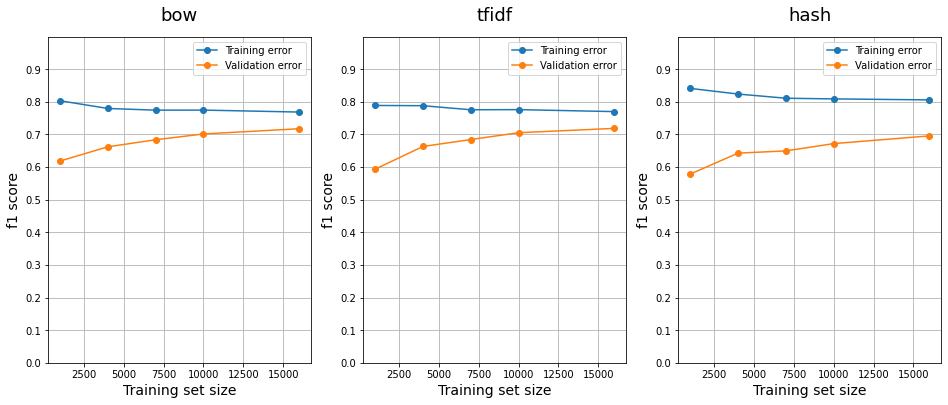

In [42]:

# use this only if we want to preprocess tweets with spacy
#train = pd.DataFrame( list(zip(train_list, traindf.label)) , columns = ['tweet', 'label'])
#test = pd.DataFrame( list(zip(test_list, valdf.label)) , columns = ['tweet', 'label'])

###################
# use this if we DONT want to pre-process with spacy the tweets
train = traindf  
test = valdf
####################

# train sizes for plotting learning curve
train_sizes = [1, 1000, 4000,7000, 10000, 15976]

classify(train,test,train_sizes)


# first is count vectorizer, second is tfidf, third is hashing vectorizer

## Use GridSearchCV to find the best hyper parameters. Do this 1 time and fix them by hand.
#####(it has my latest parameter test)

In [ ]:
# classification model
model = LogisticRegression(multi_class = 'multinomial')
# a dictionary with all possible parameters
param_grid = {
    'vect__max_df': [1.0,0.99,0.9,0.8] , 'vect__min_df' : [1,2] , 'vect__max_features' : [90000,100000] , 'vect__ngram_range' : [ (1,1),(2,2),(1,2) ], 'vect__stop_words' : [stopWordsList], 'vect__lowercase' : [False] ,
    'model__C': [ 1e-2, 1, 100], 'model__solver': ['saga','lbfgs'] , 'model__penalty':['none','l2','elasticnet']
    }
param_grid = {
    'vect__max_df': [1.0] , 'vect__min_df' : [1] , 'vect__max_features' : [1000000] , 'vect__ngram_range' : [ (1,2) ], 'vect__stop_words' : [stopWordsList], 'vect__lowercase' : [False] ,
    'model__C': [ 1, 10,15,20,25,30,50,75,100], 'model__solver': ['saga'] , 'model__penalty':['l2']
    }

# use cross validation 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

for vectorizer in [ CountVectorizer(), TfidfVectorizer(), HashingVectorizer()]:
  ppln = Pipeline([('vect', vectorizer), ('model', model)])
  gs_clf = GridSearchCV(ppln, param_grid, cv=cv, n_jobs=-1)
  gs_clf = gs_clf.fit(traindf['tweet'], traindf['label'])
  for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))